In [0]:
# Connect the notebook to the location of the data
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [0]:
root_dir = "/content/gdrive/My Drive/ML"
data_dir = root_dir + "/datasets/skin_cancer/fastai_large"

# Each label and its corresponding cell type
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [0]:
tfms = get_transforms(do_flip=True,  
                      max_rotate=10,
                      max_zoom=1.1,
                      max_warp=0.2)

data = (ImageList.from_folder(data_dir)
        .split_by_folder()          
        .label_from_folder()
        .transform(tfms, size=256)
        .databunch()
        .normalize(imagenet_stats))

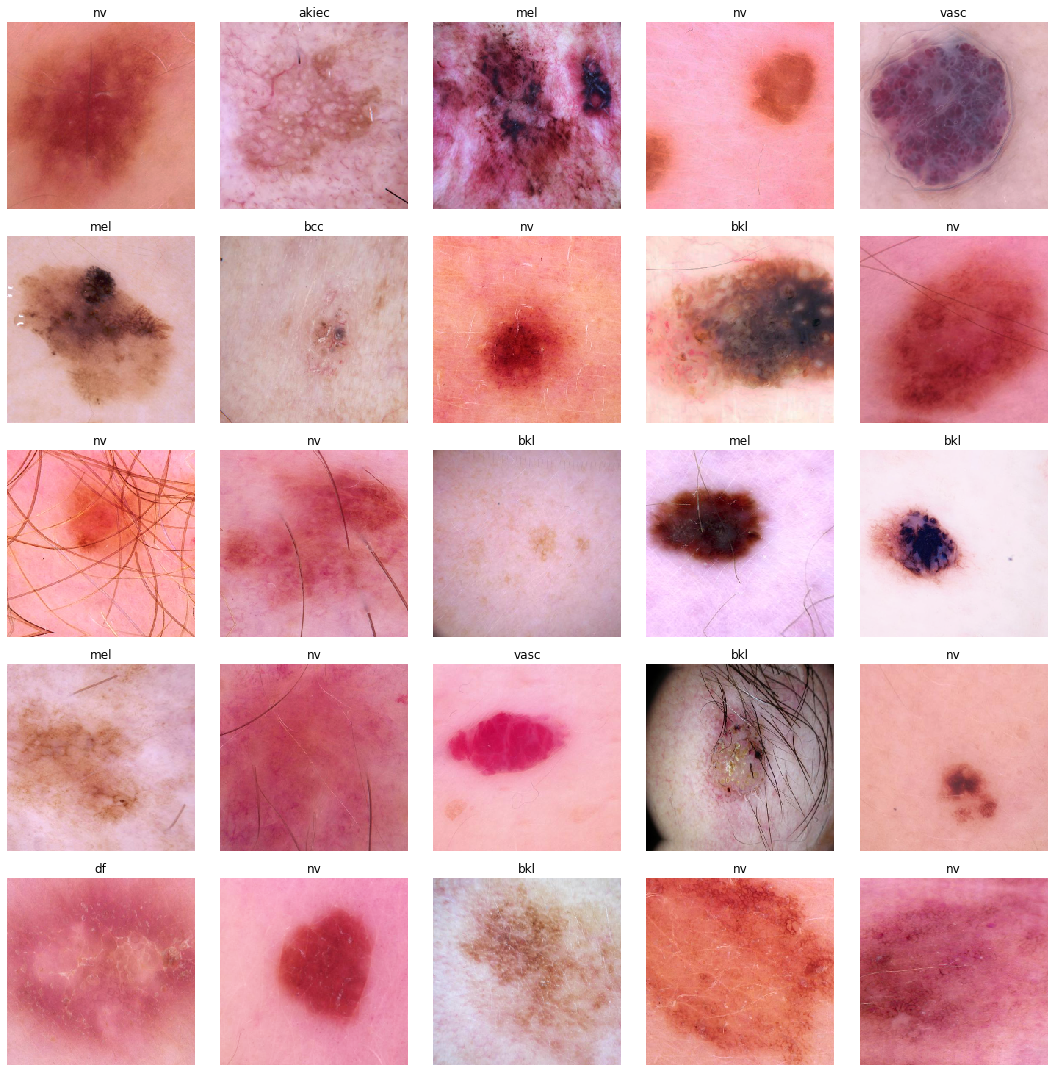

In [0]:
data.show_batch(figsize = (15,15))

In [0]:
wd=1e-2

In [0]:
learn = cnn_learner(data, models.alexnet, metrics=accuracy, wd=wd) 

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:08<00:00, 29.8MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


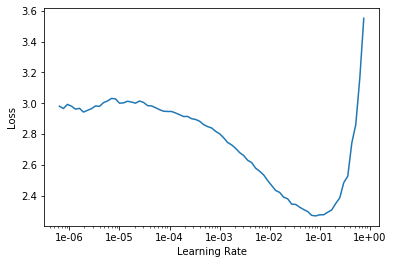

In [0]:
learn.lr_find();
learn.recorder.plot();

In [0]:
lr=3e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

In [0]:
learn.save('256_rot10_wd1e-2-stage-1')

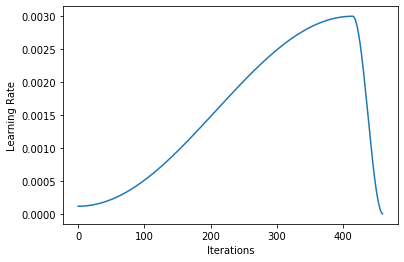

In [0]:
learn.recorder.plot_lr()

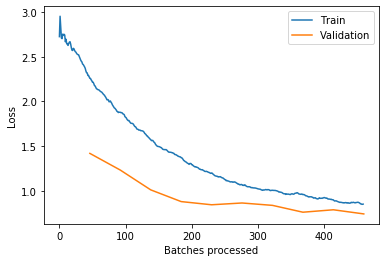

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.load('256_rot10_wd1e-2-stage-1');

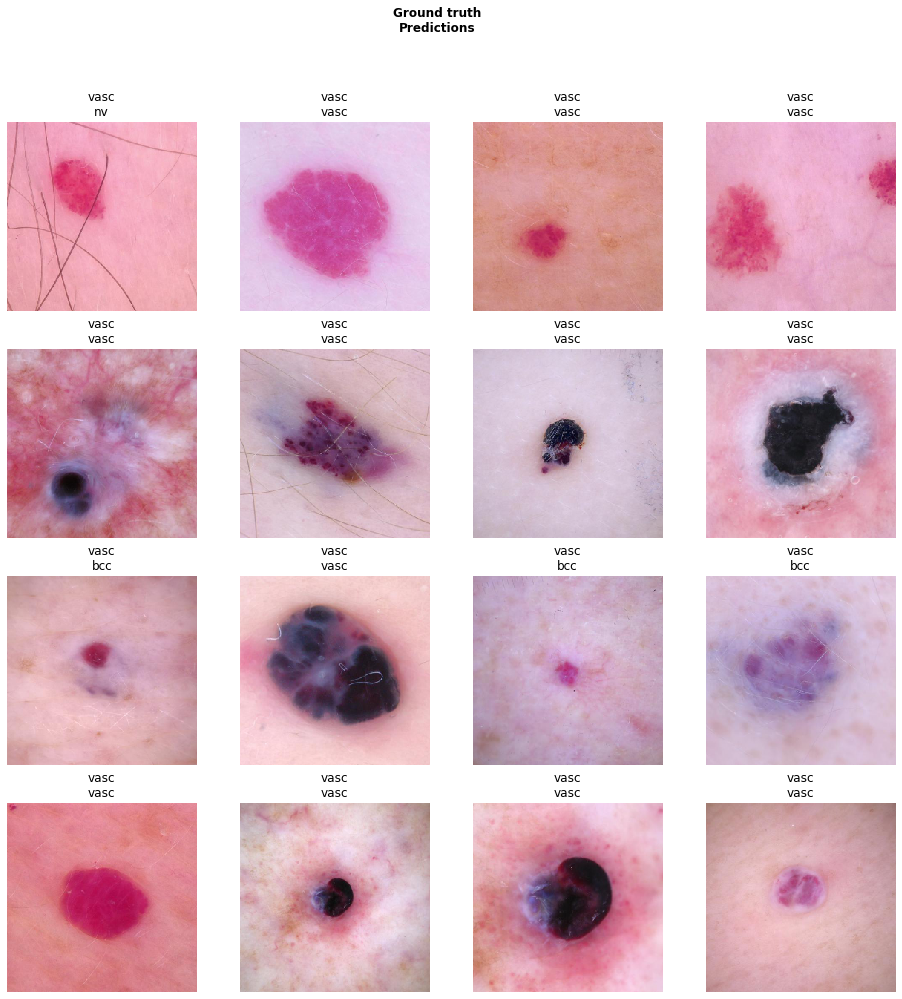

In [0]:
learn.show_results(ds_type=DatasetType.Valid, rows=4)

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [0]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

In [0]:
learn.save('256_rot10_wd1e-2-stage-2-79');

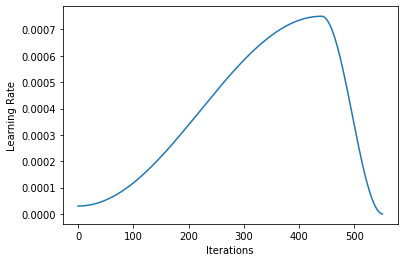

In [0]:
learn.recorder.plot_lr()

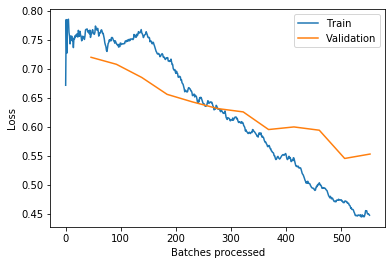

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.load('256_rot10_wd1e-2-stage-2-79');

In [0]:
learn.unfreeze()

In [0]:
# Let's see if we can bump it a little further
more_tfms = get_transforms(do_flip=True,  
                      max_rotate=20,
                      max_zoom=1.2,
                      max_warp=0.3)

more_tfms_data = (ImageList.from_folder(data_dir)
        .split_by_folder()          
        .label_from_folder()
        .transform(more_tfms, size=256)
        .databunch()
        .normalize(imagenet_stats))

In [0]:
learn.data = more_tfms_data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


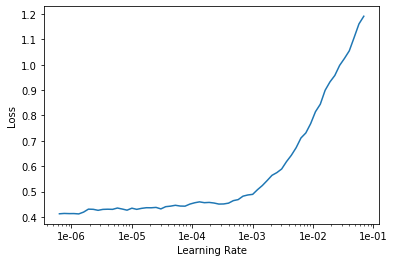

In [0]:
learn.lr_find();
learn.recorder.plot();

In [0]:
lrs=slice(1e-6, 1e-4)
learn.fit_one_cycle(3, lrs, .8)

In [0]:
learn.save('256_rot10_wd1e-2-stage-3-79');

In [0]:
learn.load('256_rot10_wd1e-2-stage-3-79');

In [0]:
learn.unfreeze()

In [0]:
# Let's see if we can bump it a little further
more_tfms = get_transforms(do_flip=True,  
                      max_rotate=10,
                      max_zoom=1.1,
                      max_warp=0.1)

more_tfms_data = (ImageList.from_folder(data_dir)
        .split_by_folder()          
        .label_from_folder()
        .transform(more_tfms, size=256)
        .databunch()
        .normalize(imagenet_stats))

In [0]:
learn.data = more_tfms_data

In [0]:
learn.fit(1, lr=slice(1e-6, 1e-5))

In [0]:
learn.fit(1, lr=slice(1e-6, 1e-5))

In [0]:
learn.save('256_rot10ish_wd1e-2-stage-4-80');

In [0]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

In [0]:
def top_k_spread(preds, y, spread):
  for i in range(spread):
    print(f"Top {i+1} accuracy: {top_k_accuracy(preds, y, i+1)}")

In [0]:
# Although our accuracy topped out at 77, our top 2 and top 3 accuracies are quite high!
# This means we could still get a lot of benefit from a tool utilizing this model.
top_k_spread(preds, y, 5)

Top 1 accuracy: 0.8032786846160889
Top 2 accuracy: 0.9332552552223206
Top 3 accuracy: 0.9824355840682983
Top 4 accuracy: 0.9929742217063904
Top 5 accuracy: 0.9988290667533875


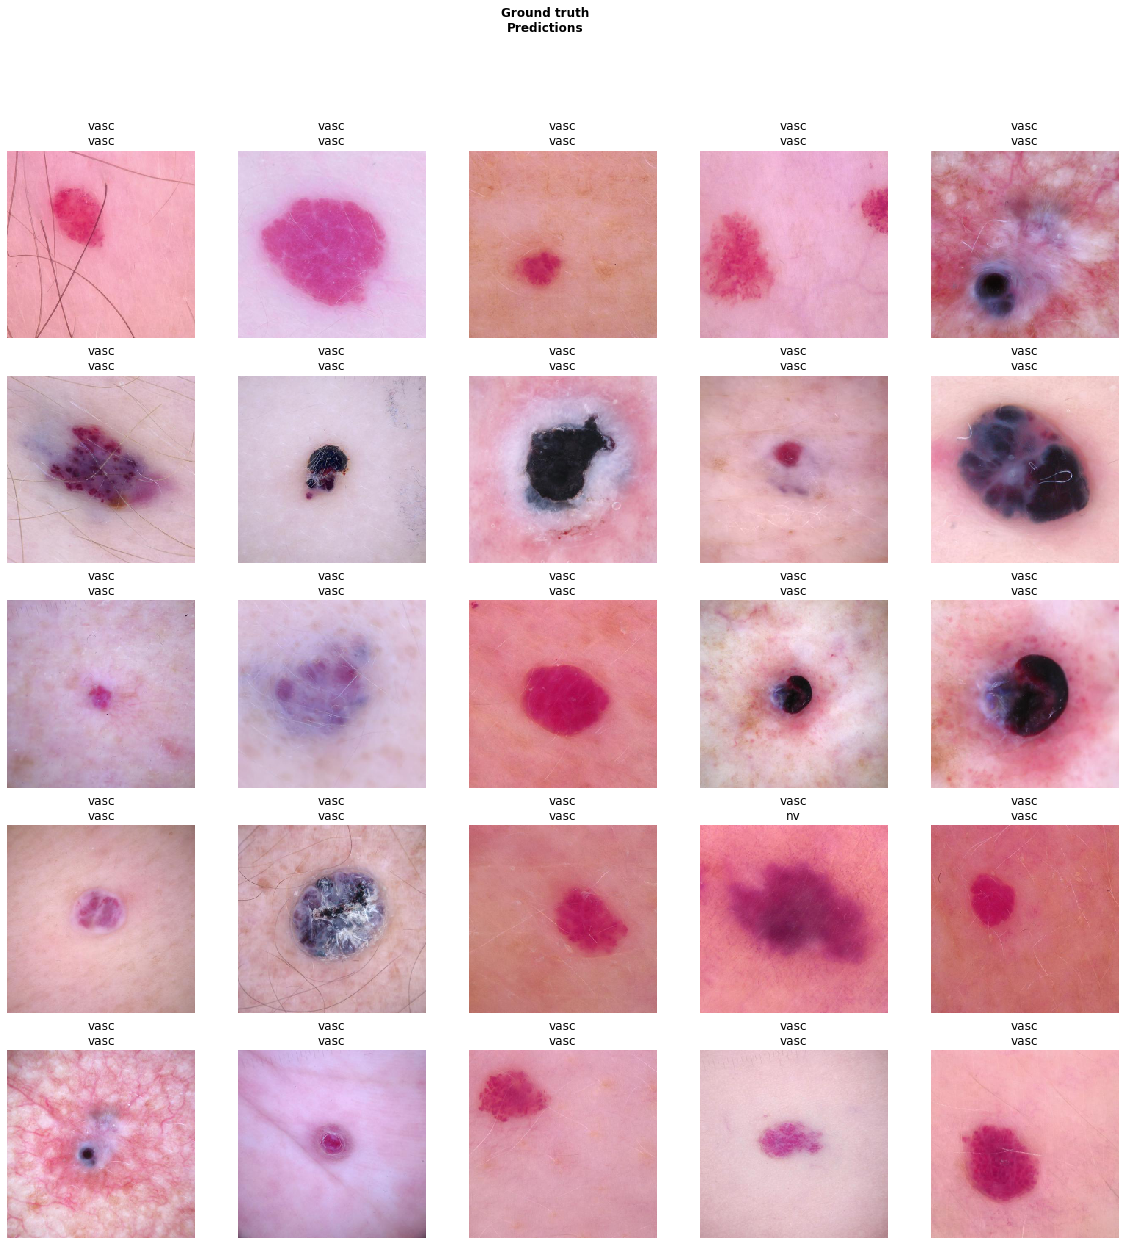

In [0]:
# Visualize some of our models predictions with the ground truth labels
learn.show_results()

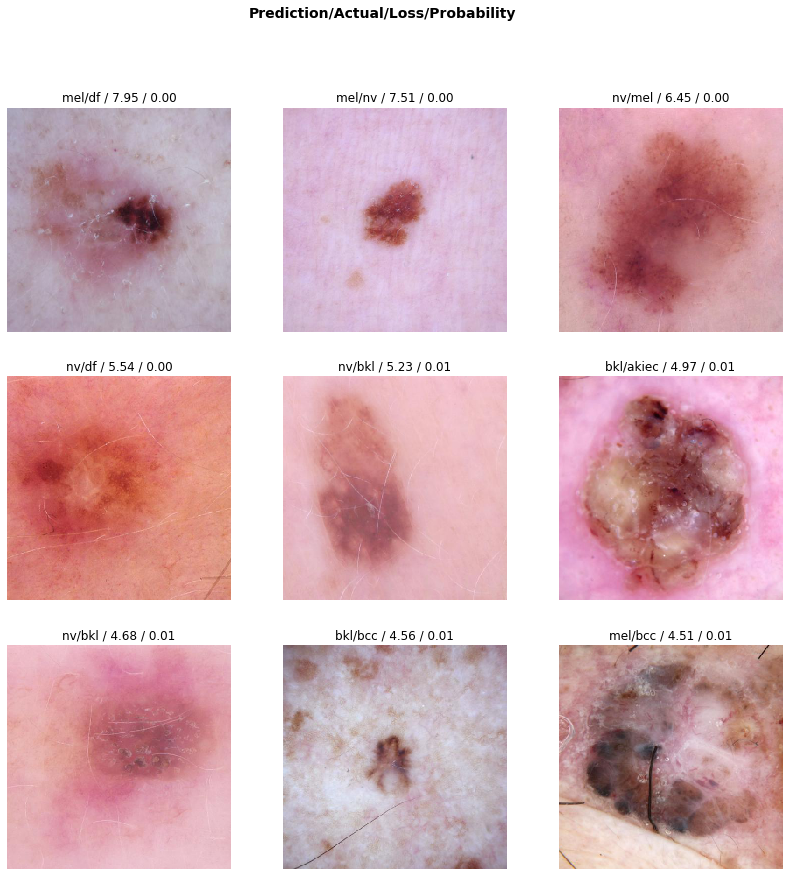

In [0]:
# Let's take a look at some of the samples that were most difficult for our model
interp.plot_top_losses(9, figsize=(14,14))

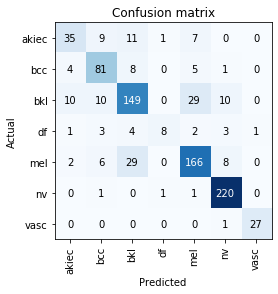

In [0]:
interp.plot_confusion_matrix()

In [0]:
# Which cell types are most often confused with eachother?
print('Actual, Predicted, Occurances')
interp.most_confused()

Actual, Predicted, Occurances


[('bkl', 'mel', 29),
 ('mel', 'bkl', 29),
 ('akiec', 'bkl', 11),
 ('bkl', 'akiec', 10),
 ('bkl', 'bcc', 10),
 ('bkl', 'nv', 10),
 ('akiec', 'bcc', 9),
 ('bcc', 'bkl', 8),
 ('mel', 'nv', 8),
 ('akiec', 'mel', 7),
 ('mel', 'bcc', 6),
 ('bcc', 'mel', 5),
 ('bcc', 'akiec', 4),
 ('df', 'bkl', 4),
 ('df', 'bcc', 3),
 ('df', 'nv', 3),
 ('df', 'mel', 2),
 ('mel', 'akiec', 2),
 ('akiec', 'df', 1),
 ('bcc', 'nv', 1),
 ('df', 'akiec', 1),
 ('df', 'vasc', 1),
 ('nv', 'bcc', 1),
 ('nv', 'df', 1),
 ('nv', 'mel', 1),
 ('vasc', 'nv', 1)]

## Examples

In [0]:
import pandas as pd
import numpy as np
from random import random

import skimage as sk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")

In [0]:
def plot_prediction(learner, index):
  data = learner.data.train_ds[index][0]
  pred = learner.predict(data)
  classes = learner.data.classes

  prediction = pd.DataFrame(to_np(pred[2]*100), columns=['Confidence'])
  prediction['Classes'] = classes
  prediction = prediction.sort_values(by='Confidence', ascending=False)

  fig = plt.figure(figsize=(12, 5))
  ax1 = fig.add_subplot(121)
  show_image(data, figsize=(5, 5), ax=ax1)
  ax2 = fig.add_subplot(122)
  sns.set_color_codes("pastel")
  sns.barplot(x='Confidence', y='Classes', data=prediction,
              label="Total", color="b")
  ax2.set_title(f'Actual: {learn.data.train_ds[index][1]}')

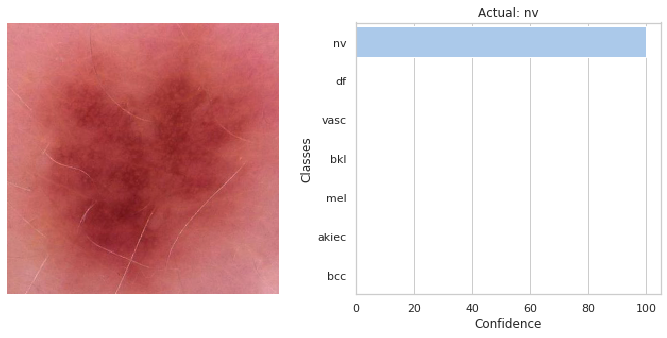

In [0]:
# Let's look at our prediciton confidence for an image in the training set
plot_prediction(learn, 913)

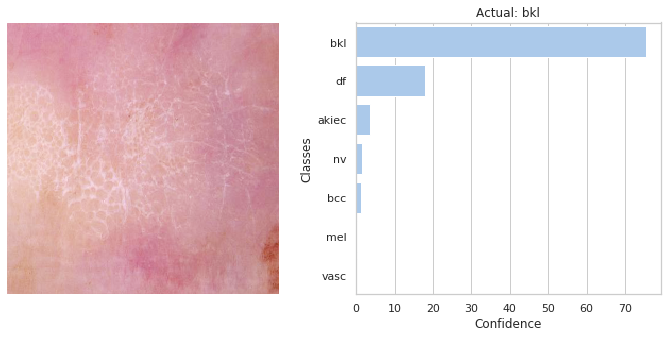

In [0]:
plot_prediction(learn, np.random.choice(len(learn.data.train_ds)))

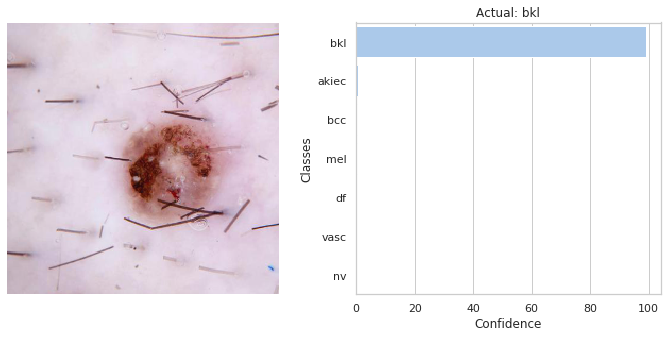

In [0]:
plot_prediction(learn, np.random.choice(len(learn.data.train_ds)))

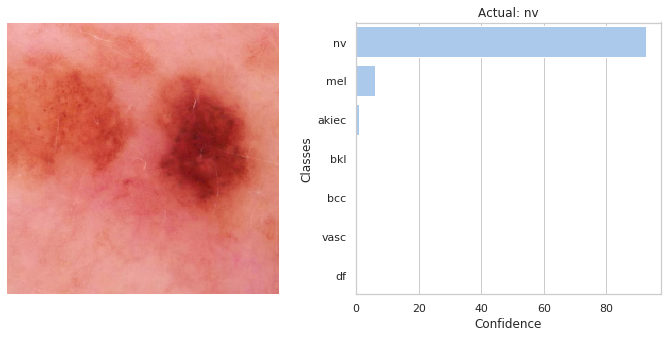

In [0]:
plot_prediction(learn, np.random.choice(len(learn.data.train_ds)))

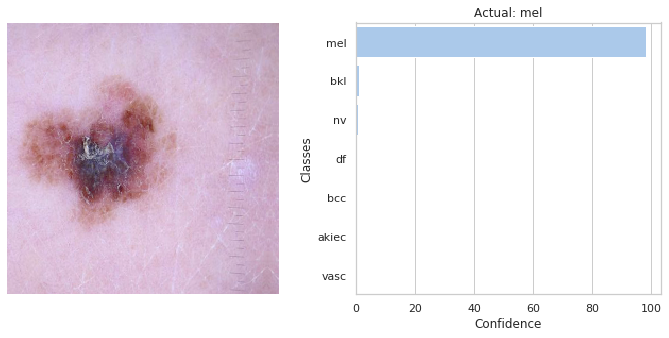

In [0]:
plot_prediction(learn, np.random.choice(len(learn.data.train_ds)))